In [19]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving a multimaterial model.

### General Libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [21]:
from mesh_utils import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './MultiMat.med')

Loaded SALOME .med mesh: 861 nodes, 980 elements
Node groups (4): ['left_e', 'right_e', 'bottom_e', 'top_e']
Element groups (14): ['GR_1_all', 'GR_1_bot_s', 'all', 'bot_s', 'GR_1_top_s', 'top_s', 'GR_1_top_e', 'top_e', 'GR_1_bottom_e', 'bottom_e', 'GR_1_right_e', 'right_e', 'GR_1_left_e', 'left_e']


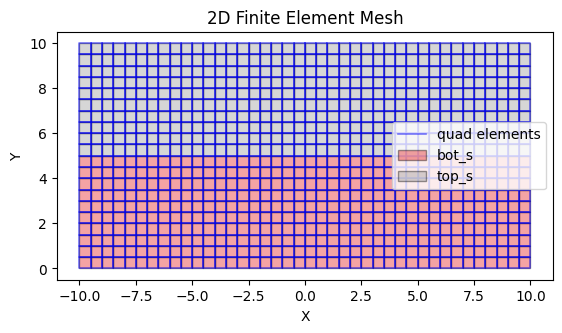

In [24]:
mesh.plot(show_nodes=False, element_groups_to_plot=['bot_s','top_s'])

### Dirichlet boundary conditions

In [25]:
from feinn_solver import BoundaryCondition

bcs = {
        'left_e': BoundaryCondition(dof=1, value=0.0),      
        'right_e': BoundaryCondition(dof=1, value=0.0),
        'bottom_e': BoundaryCondition(dof=2, value=0.0),
        }

### Define material

In [26]:
from matmodels import LinearElastic

mat1 = LinearElastic(emod = 30*1e6, nu = 0.40)
mat2 = LinearElastic(emod = 50*1e6, nu = 0.30)

matfield = {'top_s': mat1, 
            'bot_s': mat2}

### von Neumman boundary conditions

In [27]:
from feinn_solver import LineLoad

compresion = {
            'top_e': LineLoad(fx = 0.0, fy = -2*1e3, reference = "global"),
            }


### Model

In [28]:
from feinn_solver import NFEA

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      line_loads = compresion,
                      verbose = True
                      )



[matfld] Assigned: ['top_s', 'bot_s']
[matfld] All 980 elements have assigned material
[line_load] Applied 1 line load groups
[BC] Processed 3 Dirichlet condition(s) → 83 total constraint(s)
[BC] Applied Dirichlet BCs → 83 fixed DOFs


In [29]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 2.02e-14  Energetic error: 1.00e+00
Iter   2 | du error: 6.90e-15  Res error: 6.61e-15  Energetic error: -8.84e-17
Converged in 2 iterations


In [30]:
fem_solver.udisp

tensor([ 2.8546e-20, -1.4857e-04,  2.9593e-20,  ..., -1.6413e-04,
         1.0632e-20, -1.6413e-04])

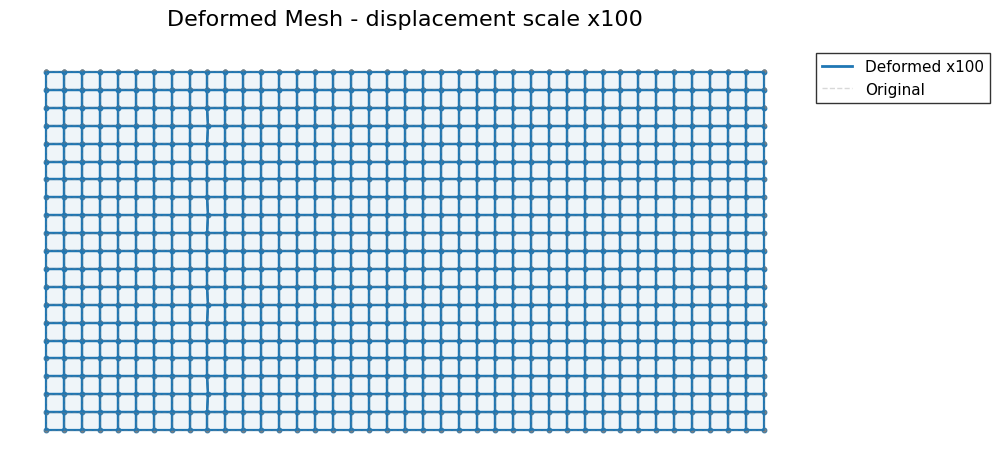

In [ ]:
fem_solver.plot_deformed_mesh(scale=1)

In [32]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    line_loads = traction,
    verbose=False,
    nnet = mFCNet(num_layers=3, num_neurons=128),
    bc_weight=1,
    nnet_init = 'xavier',
    )

NameError: name 'traction' is not defined

In [ ]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 0
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [ ]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   lbfgs_epochs = 50,
                   warmup = True, 
                   verbose = True)

In [ ]:
feinn_solver.plot_history(title="Train FEINN - Holed plate")

In [ ]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

In [ ]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')